---

# Ensemble Tree-Based Forecasting of Personal Robberies in London: Assessing Bus Stop Density Effects

<span style="color:gray;">*Student ID: 20014742*</span>

<span style="color:gray;">*Abstract:*</span>

---

## Preparation

- [Github link](google.com) *[Optional]*

- Number of words: ***

- Runtime: 24.6 minutes (*3.8GB RAM, 1.60GHz CPU (Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz)*)

- Coding environment: SDS Docker 

- License: This notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) 

In [34]:
# This cell loads the necessary packages for the workbook as follows:

# (1) Packages for data processing
import pandas as pd
import geopandas as gpd
import numpy as np
import os
!pip install gdown
import gdown

# (2) Packages for data analysis 
import statsmodels.api as sm
import libpysal
from libpysal.weights import KNN
from esda.moran import Moran
from spreg import OLS
import sklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import xgboost
from xgboost import XGBRegressor
!pip install mlxtend==0.21.0
from mlxtend.evaluate import bias_variance_decomp
from rfpimp import importances, plot_importances

# (3) Packages for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# (4) Packages for reporting runtime
import subprocess
import platform
import time
import psutil

# (4) Version checking
print("sklearn version:{}".format(sklearn.__version__))
print("xgboost version:{}".format(xgboost.__version__))

# (5) Unified random seed for consistency
random_seed = 100

# (6) Start-time timer
start_time = time.time()

sklearn version:1.5.2
xgboost version:2.1.1


---

## Table of contents

1. [Introduction](#Introduction)

1. [Research Questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and Discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [Appendix](#Appendix)

1. [References](#References)

---

## 1 | Introduction

[[ go back to the top ]](#Table-of-contents)

## 2 | Research Question

[[ go back to the top ]](#Table-of-contents)

## 3 | Data

[[ go back to the top ]](#Table-of-contents)

| Variable | Type | Implication | Source | Description |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|Personal Robbery Rate per 1000 Residents|Continuous|Target|MPS (2025)|Personal robbery incidents per 1000 residents at the LSOA level (March 2023-February 2025|
|Bus Stop Density|Continuous|Feature|OSM (2024)|Density of bus stops per hectare within each LSOA|
|Cash Access Point Density|Binary|Feature|OSM (2024)|1=LSOAs containing ATMs, banks, or post offices; 0=Otherwise|
|Distance to the Nearest Tube/Train Station|Continuous|Feature|OSM (2024)|Distance from each LSOA centroid to the nearest tube/train station in kilometers|
|Road Density|Continuous|Feature|OSM (2024)|Length of roads (kilometer per hectare) within each LSOA|
|Population Density|Continuous|Feature|ONS (2021)|Density of residents per hectare at the LSOA level|
|Proportion of Professional Workers|Continuous|Feature|ONS (2021)|Proportion of professional workers aged 16 and over according to NS-SeC categories L1-6 at the LSOA level|
|Proportion of Unemployed People|Continuous|Feature|ONS (2021)|Proportion of unemployed residents aged 16 and over according to NS-seC categories L14.1 and L14.2 at the LSOA level|
|Proportion of Less-then-2-year Residency Residents|Continuous|Feature|ONS (2021)|Proportion of residents living in the current LSOA for less than 2 years|


### 3.1 | Dependent Variable: Personal Robbery Rate per 1000 (LSOA)

In [35]:
# This cell loads the original CSV file from the London Metropolitan Police,
# which records all crime incidents in London (excluding the City of London).
# The records span from March 2023 to February 2025.

# (1) Load the original CSV
london_crime = pd.read_csv("Data/MPS LSOA Level Crime (most recent 24 months).csv")

# (2) Check data types
print(london_crime.info())

# (3) Preview the first few rows
print(london_crime.head())

# (4) Check for missing values in each column
print(london_crime.isna().sum())

# (5) Display unique minor crime category names (useful for filtering)
print(london_crime['Minor Category'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100778 entries, 0 to 100777
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA Code       100778 non-null  object
 1   LSOA Name       100778 non-null  object
 2   Borough         100778 non-null  object
 3   Major Category  100778 non-null  object
 4   Minor Category  100778 non-null  object
 5   202303          100778 non-null  int64 
 6   202304          100778 non-null  int64 
 7   202305          100778 non-null  int64 
 8   202306          100778 non-null  int64 
 9   202307          100778 non-null  int64 
 10  202308          100778 non-null  int64 
 11  202309          100778 non-null  int64 
 12  202310          100778 non-null  int64 
 13  202311          100778 non-null  int64 
 14  202312          100778 non-null  int64 
 15  202401          100778 non-null  int64 
 16  202402          100778 non-null  int64 
 17  202403          100778 non-nu

In [36]:
# This cell filters and aggregates personal robbery counts by LSOA

# (1) Filter out personal robberies and aggregate by LSOA code
robbery_counts = (
    london_crime[london_crime['Minor Category'] == 'ROBBERY OF PERSONAL PROPERTY']
    .groupby('LSOA Code')
    .sum(numeric_only=True)
    .reindex(london_crime['LSOA Code'].unique(), fill_value=0)
    .reset_index()
)

# (2) Calculate the total number of robberies for each LSOA
robbery_counts['total_robberies'] = robbery_counts.drop(columns='LSOA Code').sum(axis=1)

# (3) Keep only the relevant columns
london_robbery = robbery_counts[['LSOA Code', 'total_robberies']]

# (4) Check structure, preview the data, and verify missing values
print(london_robbery.info(), london_robbery.head(), london_robbery.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   LSOA Code        4988 non-null   object
 1   total_robberies  4988 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.1+ KB
None    LSOA Code  total_robberies
0  E01003479               20
1  E01002717                4
2  E01004649               16
3  E01003345                3
4  E01004001                1 LSOA Code          0
total_robberies    0
dtype: int64


In [37]:
# This cell merges LSOA population data with robbery data and calculates the robbery rate per 1,000 people.

# (1) Load LSOA population data from the Census 2021 survey on age
london_population = pd.read_csv("Data/Controls/ONS_LSOA_Age.csv")[['geography code', 'Age: Total']] \
    .rename(columns={'Age: Total': 'total_population'})

# (2) Merge LSOA personal robbery data with population data and drop unnecessary columns
london_robbery = pd.merge(
    london_robbery,
    london_population,
    left_on='LSOA Code',
    right_on='geography code',
    how='left'
).drop(columns=['geography code'])

# (3) Calculate robbery rate per 1,000 people
london_robbery['robberies_per_1000'] = (london_robbery['total_robberies'] / london_robbery['total_population']) * 1000

# (4) Inspect data
print(london_robbery.info(), london_robbery.head(), london_robbery.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LSOA Code           4988 non-null   object 
 1   total_robberies     4988 non-null   int64  
 2   total_population    4988 non-null   int64  
 3   robberies_per_1000  4988 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 156.0+ KB
None    LSOA Code  total_robberies  total_population  robberies_per_1000
0  E01003479               20              1547           12.928248
1  E01002717                4              1206            3.316750
2  E01004649               16              1411           11.339476
3  E01003345                3              1959            1.531394
4  E01004001                1              1767            0.565931 LSOA Code             0
total_robberies       0
total_population      0
robberies_per_1000    0
dtype: int64


In [38]:
# This cell loads the LSOAs in London and transforms them to the CRS of the British National Grid

london_lsoa = gpd.read_file('LSOA Boundaries/LSOA_2021_EW_BSC_V4.shp')
london_lsoa = london_lsoa.to_crs(epsg=27700)
print(london_lsoa)

        LSOA21CD                   LSOA21NM           LSOA21NMW   BNG_E  \
0      E01000001        City of London 001A                None  532123   
1      E01000002        City of London 001B                None  532480   
2      E01000003        City of London 001C                None  532239   
3      E01000005        City of London 001E                None  533581   
4      E01000006  Barking and Dagenham 016A                None  544994   
...          ...                        ...                 ...     ...   
35667  W01002036     Vale of Glamorgan 005G  Bro Morgannwg 005G  317939   
35668  W01002037     Vale of Glamorgan 005H  Bro Morgannwg 005H  318527   
35669  W01002038     Vale of Glamorgan 014G  Bro Morgannwg 014G  306491   
35670  W01002039     Vale of Glamorgan 014H  Bro Morgannwg 014H  306564   
35671  W01002040     Vale of Glamorgan 015F  Bro Morgannwg 015F  311423   

        BNG_N      LAT      LONG                              GlobalID  \
0      181632  51.5182 -0

In [39]:
# This cell converts 'london_robbery' into GeoDataFrame & calculates the LSOA area

# (1) Merge robbery data with LSOA boundaries 
london_robbery = pd.merge(
    london_robbery,         
    london_lsoa,        
    how='left',          
    left_on='LSOA Code',  
    right_on='LSOA21CD'    
)

# (2) Convert 'london_robbery' to a GeoDataFrame to calculate the area of each LSOA in hectares
london_robbery = gpd.GeoDataFrame(london_robbery, geometry='geometry')
london_robbery['lsoa_area_hectares'] = london_robbery.geometry.area / 10000 

# (3) Keep only the necessary columns
london_robbery = london_robbery[['LSOA21CD', 'LSOA21NM', 'robberies_per_1000', 'total_population','lsoa_area_hectares','geometry']]

# (4) Data inspection
print(london_robbery['lsoa_area_hectares'].info(), london_robbery['lsoa_area_hectares'].head(), london_robbery['lsoa_area_hectares'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: lsoa_area_hectares
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    28.093154
1    11.173799
2    16.465845
3    12.012381
4    18.092407
Name: lsoa_area_hectares, dtype: float64 0


The mean personal robbery rate (per 1000) across LSOAs is: 6.1669680638839655
The lowest personal robbery rate (per 1000) across LSOAs is: 0.0
The highest personal robbery rate (per 1000) across LSOAs is: 623.5119047619048
The upper Tukey's fence for personal robbery rate (per 1000) is: 13.96145484078158


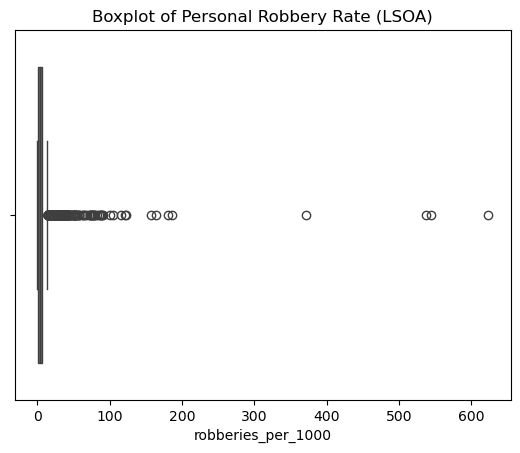

              LSOA21NM  robberies_per_1000
1226  Westminster 013B          623.511905
375   Westminster 018A          544.648137
4159  Westminster 013G          537.197627
1834  Westminster 018C          370.824813
4782       Newham 039D          186.536902
The number of LSOAs with a personal robbery rate of 0 is: 355


In [40]:
# This cell produces the descriptive statistics for the personal robbery rate

# (1) Range
mean_rate = london_robbery['robberies_per_1000'].mean()
min_rate = london_robbery['robberies_per_1000'].min()
max_rate = london_robbery['robberies_per_1000'].max()
print(f"The mean personal robbery rate (per 1000) across LSOAs is: {mean_rate}")
print(f"The lowest personal robbery rate (per 1000) across LSOAs is: {min_rate}")
print(f"The highest personal robbery rate (per 1000) across LSOAs is: {max_rate}")

# (2) Upper Tukey's Fence (for determining the color bins and range in the following visualization
Q1_rob = london_robbery['robberies_per_1000'].quantile(0.25)
Q3_rob = london_robbery['robberies_per_1000'].quantile(0.75)
IQR_rob = Q3_rob - Q1_rob
upper_tukey_fence_rob = Q3_rob + 1.5 * IQR_rob
print(f"The upper Tukey's fence for personal robbery rate (per 1000) is: {upper_tukey_fence_rob}")

# (3) Box Plot
sns.boxplot(x=london_robbery['robberies_per_1000'])
plt.title('Boxplot of Personal Robbery Rate (LSOA)')
plt.show()

# (4) Top 5 LSOAs
top5_robbery = london_robbery.sort_values(by='robberies_per_1000', ascending=False).head(5)
print(top5_robbery[['LSOA21NM', 'robberies_per_1000']])

# (5) LSOAs with 0 personal robbery rate 
zero_robberies_count = (london_robbery['robberies_per_1000'] == 0).sum()
print(f"The number of LSOAs with a personal robbery rate of 0 is: {zero_robberies_count}")

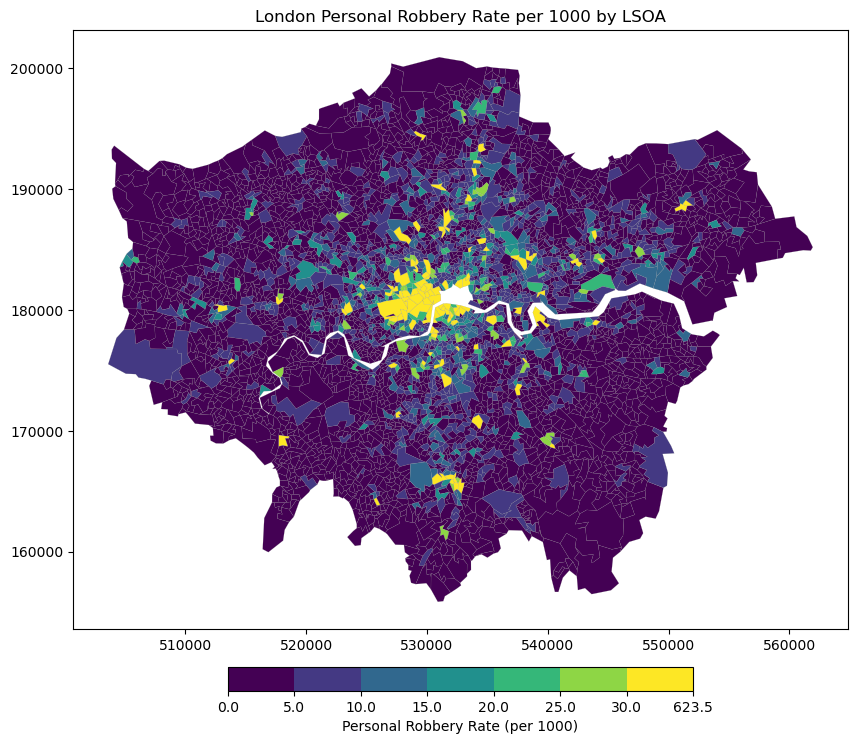

In [41]:
# This cell visualises the personal robbery rate across LSOAs through choropleth map

bins = [0, 5, 10, 15, 20, 25, 30, london_robbery['robberies_per_1000'].max()]
cmap = plt.cm.viridis
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
map_plot = london_robbery.plot(
    column='robberies_per_1000',
    ax=ax,
    cmap=cmap,
    norm=norm,
    legend=False,
    linewidth=0.1,
    edgecolor='grey'
)

plt.title("London Personal Robbery Rate per 1000 by LSOA")
cbar = fig.colorbar(map_plot.get_children()[0], ax=ax, orientation="horizontal", shrink=0.6, pad=0.05)
cbar.set_label("Personal Robbery Rate (per 1000)")

plt.show()

### 3.2 | Independent Variables

**3.2.1 | Key Predictor: Bus Stop Density (per Hectare)**

In [42]:
# This cell loads the OpenStreetMap transport shapefile.

# (1) Read the shapefile for transport data & Align the CRS
london_osm_transport = gpd.read_file('OSM/gis_osm_transport_free_1.shp')
london_osm_transport = london_osm_transport.to_crs(epsg=27700)

# (2) Extract unique types of transportation feature
unique_fclass_transport = london_osm_transport['fclass'].unique()
print(london_osm_transport)
print("Unique values in the 'fclass' column:")
print(unique_fclass_transport)

            osm_id  code           fclass                         name  \
0           780856  5601  railway_station       Shepherd's Bush Market   
1          1256794  5601  railway_station                 West Drayton   
2          2013971  5601  railway_station             Finchley Central   
3          9780241  5601  railway_station                 St Mary Cray   
4         13884199  5601  railway_station           Mill Hill Broadway   
...            ...   ...              ...                          ...   
20973  12254780537  5601  railway_station     St Pancras International   
20974  12276934800  5641             taxi  Comfort Transport Mini Cabs   
20975  12281800275  5621         bus_stop                    Ash Grove   
20976  12286269903  5601  railway_station             Liverpool Street   
20977  12286348878  5601  railway_station             Liverpool Street   

                            geometry  
0      POINT (523194.301 180061.741)  
1        POINT (506147.43 180085.

In [43]:
# The cell extracts and identifies the total number of (duplicated) bus stop names.

# (1) Extract all bus stops from 'london_osm_transport'
bus_stops = london_osm_transport[london_osm_transport['fclass'].str.lower() == 'bus_stop']
print(bus_stops)

# (2) Find all duplicated bus stop names
duplicates = bus_stops[bus_stops['name'].duplicated(keep=False)]

# (3) Count the total number of unique bus stop names that are duplicated
duplicate_count = duplicates['name'].nunique()

# (4) Find duplicates with different geometries
duplicates_with_different_geometry = duplicates.groupby('name').filter(lambda x: x['geometry'].nunique() > 1)

# (5) Count the total number of unique bus stop names that are duplicated with different geometries.
duplicates_with_diff_geom_count = duplicates_with_different_geometry['name'].nunique()

print(f"Total number of duplicated bus stop names: {duplicate_count}")
print(f"Total number of duplicated bus stop names with different geometries: {duplicates_with_diff_geom_count}")

            osm_id  code    fclass                            name  \
27        21687803  5621  bus_stop  Fleet Street / City Thameslink   
35        25477351  5621  bus_stop        Liverpool Street Station   
47        30439791  5621  bus_stop                The Great Pagoda   
48        30440982  5621  bus_stop                    Natural Area   
49        30441048  5621  bus_stop                  Brentford Gate   
...            ...   ...       ...                             ...   
20966  12061902390  5621  bus_stop       Alliance Road - Temporary   
20967  12128535503  5621  bus_stop                   Main Entrance   
20968  12152394302  5621  bus_stop                  Bolder Academy   
20969  12153596062  5621  bus_stop                 Station Terrace   
20975  12281800275  5621  bus_stop                       Ash Grove   

                            geometry  
27     POINT (531608.755 181296.697)  
35     POINT (533272.182 181580.605)  
47     POINT (518493.443 176013.177)  
48 

In [44]:
# An interactive map can be created using the folium package by uncommenting the code below.
# This was not visualized in the current workbook to save computation cost:

#import folium
#from folium.plugins import MarkerCluster
#map_london = folium.Map(location=[51.5074, -0.1278], zoom_start=12)
#marker_cluster = MarkerCluster().add_to(map_london)
#for _, row in bus_stops.iterrows():
    #folium.Marker(
        #location=[row['geometry'].y, row['geometry'].x],  # Access latitude and longitude
        #popup=row['name'],  # Show the bus stop name on click
        #icon=folium.Icon(color='blue', icon='cloud')  # Optional: Custom marker icon
    #).add_to(marker_cluster)
#map_london

In [45]:
# This cell calculates a key predictor of bus stop density per hectare (LSOA).

# (1) Perform a spatial join to count the number of bus stops within each LSOA.
bus_stop_counts = gpd.sjoin(london_robbery, bus_stops, how="left", predicate='intersects').groupby('LSOA21CD').size()

# (2) Merge the bus stop counts into 'london_robbery' and calculate bus stop density.
london_robbery['bus_stop_count'] = london_robbery['LSOA21CD'].map(bus_stop_counts).fillna(0)
london_robbery['bus_stop_density'] = london_robbery['bus_stop_count'] / london_robbery['lsoa_area_hectares']

# (3) Drop the 'bus_stop_count' column
london_robbery.drop(columns=['bus_stop_count'], inplace=True)

# (4) Data inspection
print(london_robbery['bus_stop_density'].info(), london_robbery['bus_stop_density'].head(), london_robbery['bus_stop_density'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: bus_stop_density
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.035596
1    0.089495
2    0.182195
3    0.083247
4    0.165815
Name: bus_stop_density, dtype: float64 0


The mean bus stop density across LSOAs is: 0.19776175516583333 per hectare
The lowest bus stop density across LSOAs is: 0.0028690746240011013 per hectare
The highest bus stop density across LSOAs is: 7.977826917780478 per hectare
The upper Tukey's fence for bus stop density is: 0.5102227705630196 per hectare


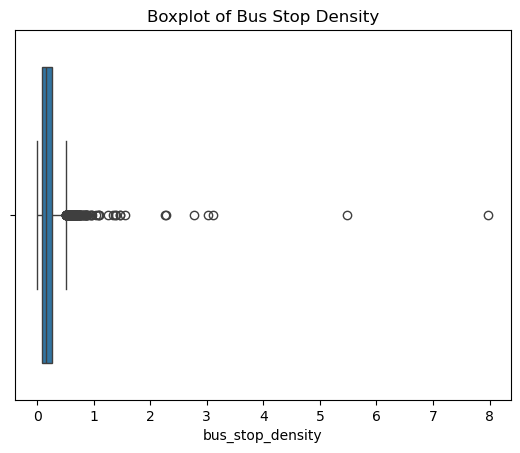

                LSOA21NM  bus_stop_density
1606         Ealing 042B          7.977827
4397      Greenwich 037F          5.480329
2507  Tower Hamlets 032G          3.110852
303       Southwark 035D          3.028147
4604          Brent 035C          2.776442


In [46]:
# This cell produces the descriptive statistics for the key predictor

# (1) Range
mean_density = london_robbery['bus_stop_density'].mean()
min_density = london_robbery['bus_stop_density'].min()
max_density = london_robbery['bus_stop_density'].max()
print(f"The mean bus stop density across LSOAs is: {mean_density} per hectare")
print(f"The lowest bus stop density across LSOAs is: {min_density} per hectare")
print(f"The highest bus stop density across LSOAs is: {max_density} per hectare")

# (2) Upper Tukey's Fence (for determining the color bins and range in the following visualization
Q1 = london_robbery['bus_stop_density'].quantile(0.25)
Q3 = london_robbery['bus_stop_density'].quantile(0.75)
IQR = Q3 - Q1
upper_tukey_fence = Q3 + 1.5 * IQR
print(f"The upper Tukey's fence for bus stop density is: {upper_tukey_fence} per hectare")

# (3) Box Plot
sns.boxplot(x=london_robbery['bus_stop_density'])
plt.title('Boxplot of Bus Stop Density')
plt.show()

# (4) Top 5 LSOAs
top5_bus = london_robbery.sort_values(by='bus_stop_density', ascending=False).head(5)
print(top5_bus[['LSOA21NM', 'bus_stop_density']])

| Variable                            | Type         | Description                                                             |Notes   |
|-------------------------------------|--------------|-------------------------------------------------------------------------|---|
| Burglary crime rate                 | Numeric      | The burglary rate of MSOAs. Used as dependent variables in regression.  |   |
| Temperature                         | Numeric      | The daytime temperature                                                 |   |
| Indicator of Inner or Outer London  | Categorical  | Whether the MSOA is in Inner London.                                    |   |
| ......  | ......  | ......                                    |   |

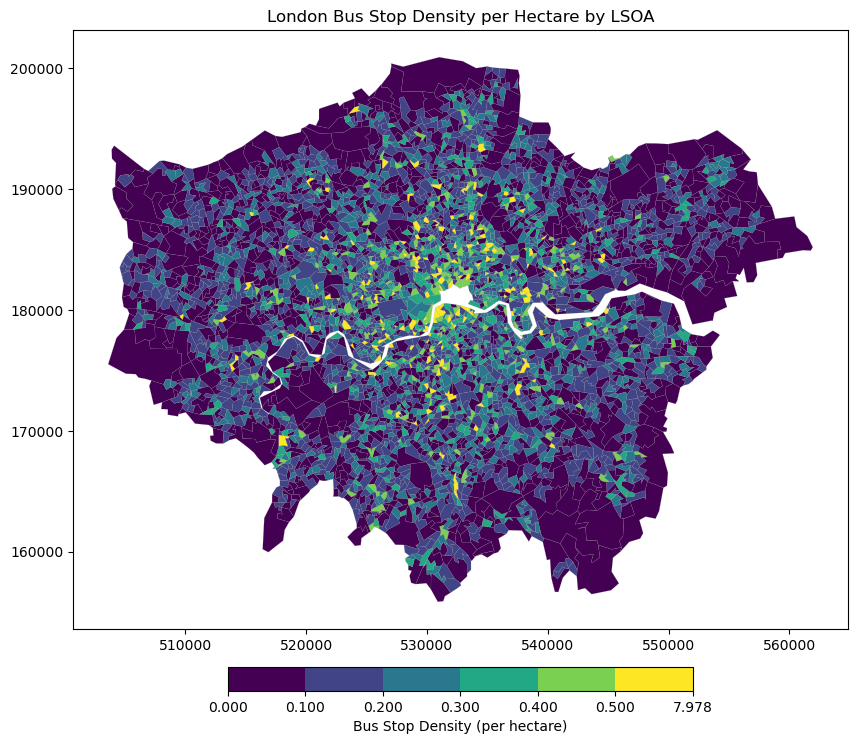

In [47]:
# This cell visualises the bus stop density across London LSOAs

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, london_robbery['bus_stop_density'].max()]
cmap = plt.cm.viridis
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
map_plot = london_robbery.plot(
    column='bus_stop_density',
    ax=ax,
    cmap=cmap,
    norm=norm,
    legend=False,
    linewidth=0.1,
    edgecolor='grey'
)

plt.title("London Bus Stop Density per Hectare by LSOA")
cbar = fig.colorbar(map_plot.collections[0], ax=ax, orientation="horizontal", shrink=0.6, pad=0.05)
cbar.set_label("Bus Stop Density (per hectare)")

plt.show()

**3.2.2 | Cash Access Point Density (per Hectare)**

In [48]:
# (1) Load and reproject POIs
cash_pois = gpd.read_file("OSM/gis_osm_pois_free_1.shp").to_crs(epsg=27700)

# (2) Filter for cash-access points
cash_classes = ['bank', 'atm', 'post_office']
cash_pois = cash_pois[cash_pois['fclass'].str.lower().isin(cash_classes)]

# (3) Spatial join: identify LSOAs intersecting cash POIs
data_with_cash = gpd.sjoin(london_robbery, cash_pois, how='left', predicate='intersects')

# (4) Assign binary indicator
london_robbery['cash_binary'] = 0  
london_robbery.loc[data_with_cash.index[data_with_cash['index_right'].notna()], 'cash_binary'] = 1
london_robbery['cash_binary'] = london_robbery['cash_binary'].astype(int)

cash_counts = london_robbery['cash_binary'].value_counts()
print(f"LSOAs with cash access points (1): {cash_counts.get(1, 0)}")
print(f"LSOAs without cash access points (0): {cash_counts.get(0, 0)}")
print(london_robbery['cash_binary'].info(), london_robbery['cash_binary'].head(), london_robbery['cash_binary'].isna().sum())

LSOAs with cash access points (1): 1207
LSOAs without cash access points (0): 3781
<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: cash_binary
Non-Null Count  Dtype
--------------  -----
4988 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB
None 0    0
1    0
2    0
3    1
4    0
Name: cash_binary, dtype: int64 0


**3.2.3 | Distance to the Nearest Tube/Railway Station (KM)**

In [49]:
# (1) Filter OSM transport features to keep only railway stations
railway_stations = london_osm_transport[london_osm_transport['fclass'].str.lower() == 'railway_station']

# (2) Extract centroids for each LSOA 
london_robbery['centroid'] = london_robbery.geometry.centroid

# (3) Calculate the distance (in km) from each LSOA centroid to the nearest railway station
london_robbery['distance_rail'] = london_robbery['centroid'].apply(
    lambda c: railway_stations.geometry.distance(c).min() / 1000
)

# (4) Drop centroid column 
london_robbery.drop(columns=['centroid'], inplace=True)

print(london_robbery['distance_rail'].info(), london_robbery['distance_rail'].head(), london_robbery['distance_rail'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: distance_rail
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.403001
1    0.292964
2    0.156225
3    0.180423
4    0.385058
Name: distance_rail, dtype: float64 0


**3.2.4 | Road Density (KM/Hectare)**

In [50]:
# This cell loads the shapefile from Google Drive folder 

file_id = '1gLGMbDT4OuxRQ7UaRALvhu2w9QfdShYp'  
download_url = f'https://drive.google.com/uc?id={file_id}'
output_folder = 'OSM'  
output_shp = f'{output_folder}/gis_osm_roads_free_1.shp'
gdown.download(download_url, output_shp, quiet=False)
london_road = gpd.read_file(output_shp)
print(london_road.head())
london_road.geometry.type.value_counts()

Downloading...
From: https://drive.google.com/uc?id=1gLGMbDT4OuxRQ7UaRALvhu2w9QfdShYp
To: /home/jovyan/work/OSM/gis_osm_roads_free_1.shp
100%|██████████| 69.2M/69.2M [00:10<00:00, 6.74MB/s]


  osm_id  code       fclass              name    ref oneway  maxspeed  layer  \
0     74  5113      primary     Ballards Lane   A598      B        48      0   
1     75  5113      primary         High Road  A1000      B        48      0   
2     79  5113      primary     East End Road   A504      B        48      0   
3    482  5113      primary  Cockfosters Road   A111      B        48      0   
4    488  5122  residential       Western Way   None      B        32      0   

  bridge tunnel                                           geometry  
0      F      F  LINESTRING (-0.19312 51.60172, -0.19297 51.60186)  
1      F      F  LINESTRING (-0.17679 51.61732, -0.17679 51.616...  
2      F      F  LINESTRING (-0.19799 51.59712, -0.19778 51.596...  
3      F      F  LINESTRING (-0.16049 51.67116, -0.16024 51.670...  
4      F      F  LINESTRING (-0.18865 51.64062, -0.18862 51.640...  


LineString    17094
Point           452
Name: count, dtype: int64

In [51]:
# This cell calculates the road density per LSOA & joined to the main dataframe

# (1) 'london_road' preprocessing
london_road = london_road[london_road.geometry.type == 'LineString']
london_road = london_road.to_crs(epsg=27700)

# (2) Calculate and aggregate road lengths by LSOA
roads_within_lsoas = gpd.overlay(london_road, london_robbery, how='intersection')
roads_within_lsoas['road_length_km'] = roads_within_lsoas.geometry.length / 1000
road_lengths_per_lsoa = roads_within_lsoas.groupby('LSOA21CD').agg({'road_length_km': 'sum'}).reset_index()

# (3) Calculate the road density per LSOA (km per hectare) 
london_robbery = london_robbery.merge(road_lengths_per_lsoa, how='left', on='LSOA21CD')
london_robbery['road_density'] = london_robbery['road_length_km'] / london_robbery['lsoa_area_hectares']
london_robbery['road_density'] = london_robbery['road_density'].fillna(0).astype(float)

# (4) Keep only necessary columns
london_robbery.drop(columns=['road_length_km'], inplace=True)

print(london_robbery['road_density'].info(), london_robbery['road_density'].head(), london_robbery['road_density'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: road_density
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.002467
1    0.005220
2    0.012575
3    0.013506
4    0.002348
Name: road_density, dtype: float64 0


**3.2.5 | Population Density (per Hectare)**

In [52]:
london_robbery['population_density'] = london_robbery['total_population'] / london_robbery['lsoa_area_hectares']
print(london_robbery['population_density'].info(), london_robbery['population_density'].head(), london_robbery['population_density'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: population_density
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0     55.066797
1    107.931061
2     85.692537
3    163.081740
4     97.665282
Name: population_density, dtype: float64 0


**3.2.6 | Proportion of High-skilled Workers & Unemployed**

In [53]:
# (1) Load the occupation data
london_occupation = pd.read_csv("Data/Controls/ONS_LSOA_Occupation.csv")

# (2) Pivot-style aggregation: sum observations per NS-SeC code per LSOA
occupation_pivot = london_occupation.groupby(
    ['Lower layer Super Output Areas Code', 'National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code']
)['Observation'].sum().unstack(fill_value=0).reset_index()

# (3) Calculate the combined professional count and proportions
occupation_pivot.rename(columns={
    1: 'Professional_1',
    2: 'Professional_2',
    8: 'Unemployed'
}, inplace=True)
occupation_pivot['Sum_Observation_Professional'] = occupation_pivot.get('Professional_1', 0) + occupation_pivot.get('Professional_2', 0)
occupation_pivot['Sum_Observation_Unemployed'] = occupation_pivot.get('Unemployed', 0)
occupation_with_pop = occupation_pivot.merge(
    london_robbery[['LSOA21CD', 'total_population']],
    left_on='Lower layer Super Output Areas Code',
    right_on='LSOA21CD',
    how='left'
)
occupation_with_pop['proportion_professional'] = occupation_with_pop['Sum_Observation_Professional'] / occupation_with_pop['total_population']
occupation_with_pop['proportion_unemployed'] = occupation_with_pop['Sum_Observation_Unemployed'] / occupation_with_pop['total_population']

# (4) Select final columns to merge
final_occupation = occupation_with_pop[[
    'Lower layer Super Output Areas Code', 'proportion_professional', 'proportion_unemployed'
]]
london_robbery = london_robbery.merge(
    final_occupation,
    how='left',
    left_on='LSOA21CD',
    right_on='Lower layer Super Output Areas Code'
).drop(columns=['Lower layer Super Output Areas Code'])

print(london_robbery['proportion_professional'].info(), london_robbery['proportion_professional'].head(), london_robbery['proportion_professional'].isna().sum())
print(london_robbery['proportion_unemployed'].info(), london_robbery['proportion_unemployed'].head(), london_robbery['proportion_unemployed'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: proportion_professional
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.162250
1    0.441957
2    0.444366
3    0.370087
4    0.236559
Name: proportion_professional, dtype: float64 0
<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: proportion_unemployed
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.093730
1    0.071310
2    0.082211
3    0.062277
4    0.149406
Name: proportion_unemployed, dtype: float64 0


**3.2.7 | Proportion of Residents Living for Less Than 2 Years**

In [54]:
# (1) Load the data
london_stability = pd.read_csv("Data/Controls/ONS_LSOA_Stability.csv")

# (2) Calculate the ratio of residents living in each LSOA for less than 2 years 
stability_filtered_l2y = london_stability[
    london_stability['Length of residence in the UK (6 categories) Code'] == 5
]
stability_output = stability_filtered_l2y.groupby('Lower layer Super Output Areas Code').agg(
    stability_output=('Observation', 'sum')
).reset_index()
stability_sum = london_stability.groupby('Lower layer Super Output Areas Code').agg(
    Total_Sum=('Observation', 'sum')
).reset_index()
stability_output['proportion_lt2'] = (
    stability_output['stability_output'] / stability_sum['Total_Sum']
)

# (3) Merge
london_robbery = london_robbery.merge(
    stability_output,
    how='left',
    left_on='LSOA21CD',
    right_on='Lower layer Super Output Areas Code'
)
london_robbery.drop(columns=['Lower layer Super Output Areas Code','stability_output'], inplace=True)

print(london_robbery['proportion_lt2'].info(), london_robbery['proportion_lt2'].head(), london_robbery['proportion_lt2'].isna().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 4988 entries, 0 to 4987
Series name: proportion_lt2
Non-Null Count  Dtype  
--------------  -----  
4988 non-null   float64
dtypes: float64(1)
memory usage: 39.1 KB
None 0    0.040078
1    0.046396
2    0.127221
3    0.017329
4    0.015271
Name: proportion_lt2, dtype: float64 0


### 3.3 | Final Dataframe Inspection

In [55]:
column_order = [
    "robberies_per_1000", "bus_stop_density", "cash_binary", "distance_rail",
    "road_density", "population_density", "proportion_professional",
    "proportion_unemployed", "proportion_lt2", "geometry"
]

london_robbery = london_robbery[column_order]
print(london_robbery.info(), london_robbery.head(), london_robbery.isna().sum())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   robberies_per_1000       4988 non-null   float64 
 1   bus_stop_density         4988 non-null   float64 
 2   cash_binary              4988 non-null   int64   
 3   distance_rail            4988 non-null   float64 
 4   road_density             4988 non-null   float64 
 5   population_density       4988 non-null   float64 
 6   proportion_professional  4988 non-null   float64 
 7   proportion_unemployed    4988 non-null   float64 
 8   proportion_lt2           4988 non-null   float64 
 9   geometry                 4988 non-null   geometry
dtypes: float64(8), geometry(1), int64(1)
memory usage: 389.8 KB
None    robberies_per_1000  bus_stop_density  cash_binary  distance_rail  \
0           12.928248          0.035596            0       0.403001   
1            

## 4 | Methodology

[[ go back to the top ]](#Table-of-contents)

![](flow_chart.png)

### 4.1 | Spatial Autocorrelation Testing

In [56]:
# This cell computes the baseline spatial autocorrelation before ML

# (1) Specify the features and target
features = [
    'bus_stop_density', 'cash_binary', 'distance_rail', 'road_density',
    'population_density', 'proportion_professional', 'proportion_unemployed',
    'proportion_lt2'
]
target = 'robberies_per_1000'
X_base = london_robbery[features]
y = london_robbery[target]

# (2) Fit the baseline OLS model
X_ols = sm.add_constant(X_base)
ols_model = sm.OLS(y, X_ols).fit()
ols_residuals = ols_model.resid

# (3) Compute the Global Moran's I
coords = [(geom.centroid.x, geom.centroid.y) for geom in london_robbery.geometry]
w = KNN(coords, k=4)
w.transform = 'R'

moran_ols = Moran(ols_residuals, w)
print("Moran's I on OLS residuals:")
print(f"    I = {moran_ols.I:.4f}, p = {moran_ols.p_norm:.4f}")

Moran's I on OLS residuals:
    I = 0.3787, p = 0.0000


In [57]:
# This cell precomputes spatial lag features

X_lagged = w.sparse.dot(X_base.values)
X_lagged_df = pd.DataFrame(X_lagged, columns=[f"{col}_lag" for col in features])
X_final = pd.concat([X_base.reset_index(drop=True), X_lagged_df], axis=1)

### 4.2 | Pipeline Setting

In [58]:
# This cell controls for reproducibility

# (1) Train/Test Split
train_x, test_x, train_y, test_y = train_test_split(
    X_final, y, test_size=0.2, random_state=random_seed
)

# (2) Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)

### 4.3 | Random Forest Setting

In [59]:
# This cell constructs the random forest pipeline 

# (1) Define the random forest pipeline
rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=random_seed))
])

# (2) Define the hyperparameter grid for tuning
rf_param_grid = {
    'rf__max_depth': [10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 4, 6, 8, 10],
    #'rf__n_estimators': [100, 200, 300, 400]
}

# (3) Set up GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# (4) Print the tuned hyperparameters
rf_grid_search.fit(train_x, train_y)
rf_best_params = rf_grid_search.best_params_
print("\nBest Params:", rf_best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Params: {'rf__max_depth': 20, 'rf__min_samples_split': 6}


### 4.4 | GBDT Setting (XGBoost)

In [60]:
# This cell constructs the GBDT pipeline 

# (1) Define the GBDT pipeline
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=random_seed))
])

# (2) Define the hyperparameter grid for tuning
xgb_param_grid = {
    'xgb__max_depth': [10, 20, 30, 40, 50],
    'xgb__n_estimators': [50, 100, 150, 200, 250],
    #'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

# (3) Set up GridSearchCV for hyperparameter tuning
xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# (4) Print the tuned hyperparameters
xgb_grid_search.fit(train_x, train_y)
xgb_best_params = xgb_grid_search.best_params_
print("\nXGBoost - Best Parameters:", xgb_best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

XGBoost - Best Parameters: {'xgb__max_depth': 10, 'xgb__n_estimators': 200}


## 5 | Results & Discussion

[[ go back to the top ]](#Table-of-contents)

### 5.1 | Random Forest Results

In [61]:
# This cell evaluates the RF model

# (1) Predict on the test set
test_preds = rf_grid_search.predict(test_x)

# (2) Compute residuals for test data
residuals_rf = test_y - test_preds

# (3) Print R² scores
print("RF Train Set R²:", rf_grid_search.best_score_)
print("RF Test Set R²:", r2_score(test_y, test_preds))

# (4) Print RMSE
print("RF Train Set RMSE:")
print(root_mean_squared_error(train_y, rf_grid_search.predict(train_x)))
print("RF Test Set RMSE:")
print(root_mean_squared_error(test_y, rf_grid_search.predict(test_x)))

# (5) Compute Moran's I on the residuals to assess spatial autocorrelation
test_coords = [
    (geom.centroid.x, geom.centroid.y)
    for geom in london_robbery.loc[test_x.index, "geometry"]
]
w_test = KNN(test_coords, k=4)
w_test.transform = "R"
moran_rf = Moran(residuals_rf, w_test)
print("\nMoran's I on Random Forest residuals:")
print(f"    I = {moran_rf.I:.4f}, p = {moran_rf.p_norm:.4f}")

RF Train Set R²: 0.2688781355156636
RF Test Set R²: 0.4035126228386706
RF Train Set RMSE:
8.331923805805959
RF Test Set RMSE:
12.160696865657666

Moran's I on Random Forest residuals:
    I = -0.0158, p = 0.4809


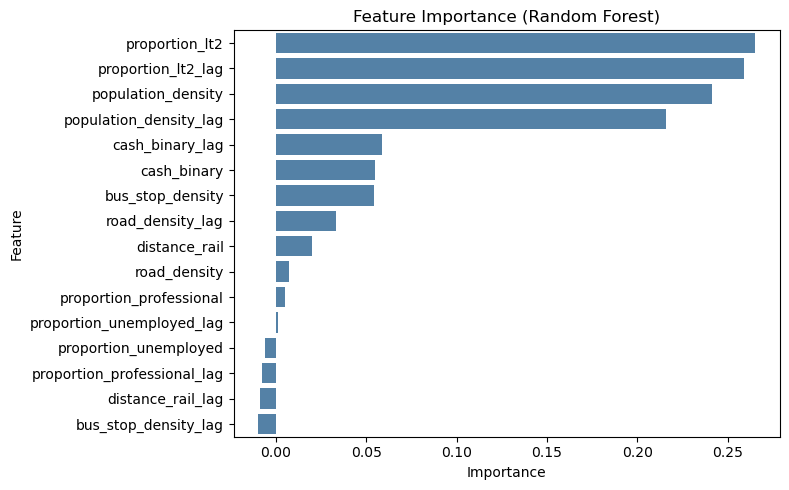

In [62]:
# This cell computes the permutation importance

# (1) Extract the fitted RF model from pipeline
rf_final = rf_grid_search.best_estimator_.named_steps['rf']

# (2) Rebuild the feature list
feature_names = features + [f"{f}_lag" for f in features]
test_x.columns = feature_names  

# (3) Compute permutation importances
# imp = importances(rf_final, test_x, test_y)
# print(imp)
# viz = plot_importances(imp)
# viz.view()

# (3) Compute feature importances (using permutation importance)
imp_rf = importances(rf_final, test_x, test_y)  
imp_rf = imp_rf.reset_index().rename(columns={'index':'Feature', 0:'Importance'})  
plt.figure(figsize=(8, 5))
sns.barplot(data=imp_rf, x='Importance', y='Feature', color='steelblue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 5.2 | GBDT Results

In [63]:
# This cell evaluates the GBDT model

# (1) Predict on the test set
xgb_test_preds = xgb_grid_search.predict(test_x)

# (2) Compute residuals for test data
xgb_residuals = test_y - xgb_test_preds

# (3) Print best parameters and R² scores
print("XGBoost Train Set R²:", xgb_grid_search.best_score_)
print("XGBoost Test Set R²:", r2_score(test_y, xgb_test_preds))

# (4) Print RMSE
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, xgb_grid_search.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, xgb_grid_search.predict(test_x)))

# (5) Compute Moran's I on the residuals to assess spatial autocorrelation
xgb_test_coords = [(geom.centroid.x, geom.centroid.y) for geom in london_robbery.loc[test_x.index, 'geometry']]
w_xgb_test = KNN(xgb_test_coords, k=4)
w_xgb_test.transform = 'R'
moran_xgb = Moran(xgb_residuals, w_xgb_test)
print("\n Moran's I on XGBoost residuals:")
print(f"    I = {moran_xgb.I:.4f}, p = {moran_xgb.p_norm:.4f}")

XGBoost Train Set R²: 0.2360591069919053
XGBoost Test Set R²: 0.390523718070789
RMSE on the training data:
0.0009745839194226768
RMSE on the testing data:
12.292387398897729

 Moran's I on XGBoost residuals:
    I = -0.0295, p = 0.1759


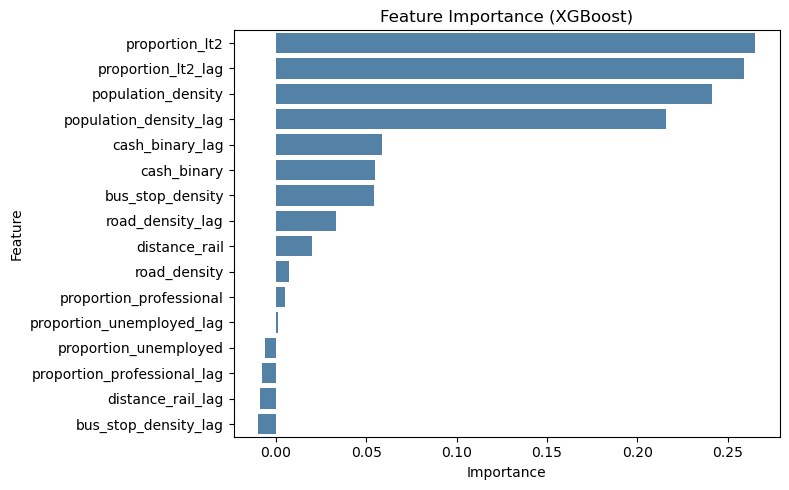

In [64]:
# This cell computes the permutation importance

# (1) Extract the fitted RF model from pipeline
xgb_final = xgb_grid_search.best_estimator_.named_steps['xgb']

# (2) Rebuild the feature list
feature_names = features + [f"{f}_lag" for f in features]
test_x.columns = feature_names  

# (3) Compute permutation importances
# imp = importances(xgb_final, test_x, test_y)
# print(imp)
# viz = plot_importances(imp)
# viz.view()

# (3) Compute feature importances (using permutation importance)
imp_xgb = importances(xgb_final, test_x, test_y)  
imp_xgb = imp_xgb.reset_index().rename(columns={'index':'Feature', 0:'Importance'})  
plt.figure(figsize=(8, 5))
sns.barplot(data=imp_rf, x='Importance', y='Feature', color='steelblue')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 5.3 | Bias-Variance Decomposition Model

In [65]:
# (1) Define unction to clean parameter names for regressors to recognise
def clean_params(best_params, prefix):
    return {k.replace(f"{prefix}__", ""): v for k, v in best_params.items()}
rf_best_params_cleaned = clean_params(rf_best_params, "rf")
xgb_best_params_cleaned = clean_params(xgb_best_params, "xgb")

# (2) Define models to compare 
regressors = {
    'RF': RandomForestRegressor(**rf_best_params_cleaned, random_state=random_seed),
    'XGB': XGBRegressor(objective='reg:squarederror', **xgb_best_params_cleaned, random_state=random_seed)
}

# (3) Dictionary to store results 
dict_results = dict()

# (4) Loop through each model and compute bias-variance decomposition 
for name, regressor in regressors.items():
    avg_expected_loss, avg_bias_squared, avg_variance = bias_variance_decomp(
        regressor,
        train_x.to_numpy(), train_y.to_numpy(),
        test_x.to_numpy(), test_y.to_numpy(),
        loss='mse',
        random_seed=random_seed,
        num_rounds=40
    )
    dict_results[name] = [
        round(avg_expected_loss, 4),
        round(avg_bias_squared, 4),
        round(avg_variance, 4)
    ]

# (5) Convert results into a DataFrame 
df_models = pd.DataFrame.from_dict(dict_results, orient='index',
                                   columns=['Total loss (MSE)', 'Bias²', 'Variance'])
df_models

,Total loss (MSE),Bias²,Variance
RF,167.9679,145.0408,22.9271
XGB,204.0318,135.7411,68.2906


### 5.4 | Retrained Models (No Bus Stop Density)

In [67]:
# This cell prepares for the new data (no bus stop density) for the retrained models

print(X_final.columns.tolist())
X_retrained = X_final.drop(columns=["bus_stop_density", "bus_stop_density_lag"])
print(X_retrained.columns.tolist())

['bus_stop_density', 'cash_binary', 'distance_rail', 'road_density', 'population_density', 'proportion_professional', 'proportion_unemployed', 'proportion_lt2', 'bus_stop_density_lag', 'cash_binary_lag', 'distance_rail_lag', 'road_density_lag', 'population_density_lag', 'proportion_professional_lag', 'proportion_unemployed_lag', 'proportion_lt2_lag']
['cash_binary', 'distance_rail', 'road_density', 'population_density', 'proportion_professional', 'proportion_unemployed', 'proportion_lt2', 'cash_binary_lag', 'distance_rail_lag', 'road_density_lag', 'population_density_lag', 'proportion_professional_lag', 'proportion_unemployed_lag', 'proportion_lt2_lag']


In [68]:
# This cell reuses the original train/test split indices to create new training and testing feature sets

# (1) Reuse the same split based on the old train/test indices
train_x_retrained = X_retrained.loc[train_x.index]
test_x_retrained = X_retrained.loc[test_x.index]

# (2) Labels stay the same
train_y_retrained = train_y
test_y_retrained = test_y

In [69]:
# This cell evaluates the retrained RF model

# (1) Extract the best parameters from original RF model for comparability
best_rf_params_cleaned = {k.replace("rf__", ""): v for k, v in rf_grid_search.best_params_.items()}

# (2) Rebuild a new RF model using the same hyperparameters
rf_retrained = RandomForestRegressor(**best_rf_params_cleaned, random_state=random_seed)

# (3) Fit the model on retrained features
rf_retrained.fit(train_x_retrained, train_y)

# (4) Predict on retrained test set
test_preds_retrained = rf_retrained.predict(test_x_retrained)

# (5) Evaluate
print("Retrained RF Test R²:", r2_score(test_y, test_preds_retrained))
print("Retrained RF Test RMSE:", root_mean_squared_error(test_y, test_preds_retrained))

Retrained RF Test R²: 0.36210628737513295
Retrained RF Test RMSE: 12.575694969721678


In [70]:
# This cell evaluates the retrained XGBoost model 

# (1) Extract the best parameters from original XGBoost model for comparability
best_xgb_params_cleaned = {k.replace("xgb__", ""): v for k, v in xgb_grid_search.best_params_.items()}

# (2) Rebuild a new XGB model using the same hyperparameters
xgb_retrained = XGBRegressor(objective="reg:squarederror", **best_xgb_params_cleaned, random_state=random_seed)

# (3) Fit the model on retrained features
xgb_retrained.fit(train_x_retrained, train_y)

# (4) Predict on retrained test set
xgb_test_preds_retrained = xgb_retrained.predict(test_x_retrained)

# (5) Evaluate 
print("Retrained XGBoost Test R²:", r2_score(test_y, xgb_test_preds_retrained))
print("Retrained XGBoost Test RMSE:", root_mean_squared_error(test_y, xgb_test_preds_retrained))

Retrained XGBoost Test R²: 0.2778812052300006
Retrained XGBoost Test RMSE: 13.380186235490704


## 6 | Conclusion

[[ go back to the top ]](#Table-of-contents)

## 7 | Appendix

[[ go back to the top ]](#Table-of-contents)

In [66]:
# This cell reports the runtime assessment

# (1) FUNCTION: Detect CPU Information 
def get_cpu_info(): 
    try:
        output = subprocess.check_output(
            'grep -m1 "model name" /proc/cpuinfo', 
            shell=True,
            stderr=subprocess.DEVNULL
        ).decode().strip()
        
        if 'model name' in output:
            cpu_name = output.split(':')[1].strip()
            if '@' in cpu_name:
                ghz_part = cpu_name.split('@')[-1].replace('GHz', '').strip()
                return f"{ghz_part}GHz CPU", cpu_name 
            else:
                return cpu_name.split('(')[0].strip(), cpu_name
    except (subprocess.CalledProcessError, FileNotFoundError): 
        pass

    # Fallback 1: Use psutil if available
    try:
        if hasattr(psutil, "cpu_freq") and (freq := psutil.cpu_freq()):
            return f"{freq.max/1000:.2f}GHz CPU", "psutil-detected" 
    except Exception:
        pass

    # Fallback 2: Default manual
    return "1.80GHz CPU", "manual-default"

# (2) Runtime Calculation
process = psutil.Process()
runtime_minutes = (time.time() - start_time) / 60

# (3) Detect system specs
cpu_spec, cpu_source = get_cpu_info()

try:
    total_memory = psutil.virtual_memory().total / (1024**3) 
    memory_spec = f"{total_memory:.1f}GB RAM"
except Exception: 
    memory_spec = "8GB RAM"

# (4) Print final results
print(f"Total runtime: {runtime_minutes:.1f} minutes\n" 
      f"Hardware: {memory_spec}, {cpu_spec} ({cpu_source})\n"
      f"OS: {platform.system()} {platform.release()}")

Total runtime: 37.2 minutes
Hardware: 3.8GB RAM, 1.60GHz CPU (Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz)
OS: Linux 6.10.14-linuxkit


## 8 | References

[[ go back to the top ]](#Table-of-contents)